<a href="https://colab.research.google.com/github/adarsh-meher/Kaggle---Predict-Real-disaster-tweets/blob/master/Kaggle_Real_or_not_Disaster_Tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/adarsh-meher/Kaggle---Predict-Real-disaster-tweets.git
import os
os.chdir('/content/Kaggle---Predict-Real-disaster-tweets/')

Cloning into 'Kaggle---Predict-Real-disaster-tweets'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [2]:
os.listdir(os.getcwd())

['README.md',
 'sample_submission.csv',
 '.git',
 'Kaggle_Real_or_not_Disaster_Tweet.ipynb',
 'test.csv',
 'train.csv']

In [3]:
!pip install fasttext
!pip install fastai
!pip install wordcloud

     |████████████████████████████████| 61kB 2.3MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.1-cp36-cp36m-linux_x86_64.whl size=2385495 sha256=64d12a9f30e489ecc2d343d2219fb8ee2b69876669129fec091bbb5f0204b389
  Stored in directory: /root/.cache/pip/wheels/9f/f0/04/caa82c912aee89ce76358ff954f3f0729b7577c8ff23a292e3
Successfully built fasttext


In [0]:
import pandas as pd
import numpy as np
import dask as D
import scipy as sc
import spacy as S
import gensim as G
import torch as T
import fasttext as ft
import fastai as fai
import hyperopt as hopt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
from wordcloud import  WordCloud, STOPWORDS , ImageColorGenerator
import nltk

In [0]:
#### List of contractions
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'd've": "he would have",
"he'll": "he shall",
"he'll've": "he shall have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I had",
"I'd've": "I would have",
"I'll": "I shall",
"I'll've": "I shall have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had",
"it'd've": "it would have",
"it'll": "it shall",
"it'll've": "it shall have",
"it's": "it has",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had",
"she'd've": "she would have",
"she'll": "she shall",
"she'll've": "she shall have",
"she's": "she has",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that has",
"there'd": "there had",
"there'd've": "there would have",
"there's": "there has",
"they'd": "they had",
"they'd've": "they would have",
"they'll": "they shall",
"they'll've": "they shall have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall",
"what'll've": "what shall have",
"what're": "what are",
"what's": "what has",
"what've": "what have",
"when's": "when has",
"when've": "when have",
"where'd": "where did",
"where's": "where has",
"where've": "where have",
"who'll": "who shall",
"who'll've": "who shall have",
"who's": "who has",
"who've": "who have",
"why's": "why has",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had",
"you'd've": "you would have",
"you'll": "you shall",
"you'll've": "you shall have",
"you're": "you are",
"you've": "you have"
}

In [0]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [124]:
train_data.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [0]:
train_data.set_index(['id'],inplace=True)
train_data.drop_duplicates(inplace = True)
train_data.reset_index(inplace= True)

test_data.set_index(['id'],inplace=True)
test_data.drop_duplicates(inplace = True)
test_data.reset_index(inplace= True)

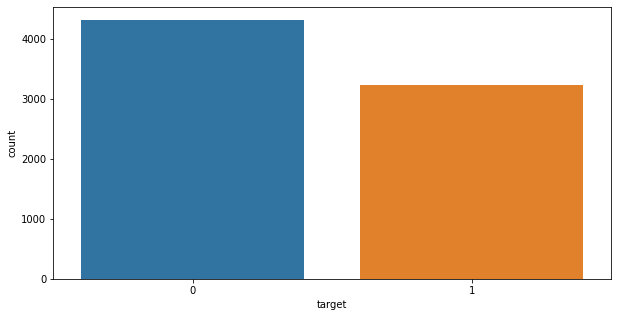

In [9]:
##### Distribution of 1/0 in train

plt.figure(figsize = (10,5))
sb.countplot(x = 'target',data = train_data)
plt.show()

### No imbalance in target distribution.

In [0]:
##### Train data summary
def data_summary(data):
  df1 = pd.DataFrame(columns = ['Column name','NA Present','Number of Uniques Except NA','Most Common Category','Least Common Category'],index = range(data.shape[1]))
  for i,c in enumerate(data.columns.tolist()):
    df1.loc[i,'Column name'] = c
    df1.loc[i,'NA Present'] = data[pd.isna(data[c])].shape[0]
    df1.loc[i,'Number of Uniques Except NA'] = data[~pd.isna(data[c])][c].nunique()
    df1.loc[i,'Least Common Category'] = data[~pd.isna(data[c])][c].value_counts().argmin()
    df1.loc[i,'Most Common Category'] = data[~pd.isna(data[c])][c].value_counts().argmax()
  return df1


In [11]:
data_summary(train_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  


,Column name,NA Present,Number of Uniques Except NA,Most Common Category,Least Common Category
0,id,0,7561,2047,2047
1,keyword,61,221,fatalities,radiation%20emergency
2,location,2500,3341,USA,"Atlanta, Georgia USA"
3,text,0,7503,11-Year-Old Boy Charged With Manslaughter of T...,When he lets you drive his truck and you start...
4,target,0,2,0,1


In [12]:
data_summary(test_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  


,Column name,NA Present,Number of Uniques Except NA,Most Common Category,Least Common Category
0,id,0,3252,10235,10235
1,keyword,26,221,deluged,epicentre
2,location,1100,1602,New York,chi town
3,text,0,3243,11-Year-Old Boy Charged With Manslaughter of T...,It doesn't get any closer. Heavy rain just bar...


In [13]:
#### counts of texts to check duplicate texts. We can then look at other attributes of duplicate texts to see what they differ in.
train_data['text'].value_counts().sort_values(ascending = False)

11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...         5
that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time                3
Madhya Pradesh Train Derailment: Village Youth Saved Many Lives                                                                                  3
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'                               3
Wreckage 'Conclusively Confirmed' as From MH370: Malaysia PM                                                                                     3
                                                                                                                                                ..
Choking Hazard Prompts Recall Of Kraft Cheese Singles http://t.co/XGKyVF9t4f                                          

In [14]:
#### look into some of repeated texts and see their other attributes
t1 = train_data['text'].value_counts()
repeated_tweets = t1[t1>1].index.values.tolist()
print("Number of repeated tweets : %s" % (len(repeated_tweets)))
t2 = train_data[train_data['text'].isin(repeated_tweets)]
t2

#### We can see that for some texts the target is same but they differ in location. For others we have different target values for same text.

Number of repeated tweets : 48


,id,keyword,location,text,target
606,881,bioterrorism,NaN,To fight bioterrorism sir.,1
620,898,bioterrorism,NaN,To fight bioterrorism sir.,0
1128,1634,bombing,NaN,Japan on Thursday marks the 70th anniversary o...,1
1150,1665,bombing,Singapore,Japan on Thursday marks the 70th anniversary o...,1
1166,1689,bridge%20collapse,"Mumbai , India",Warne shocked over Australia's epic collapse a...,1
...,...,...,...,...,...
7548,10855,NaN,NaN,Evacuation order lifted for town of Roosevelt:...,1
7555,10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1
7557,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7558,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


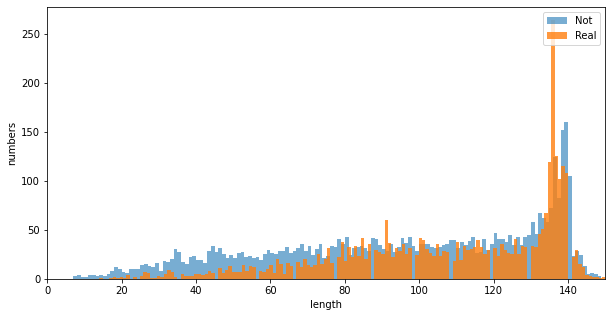

In [126]:
##### Number of characters in tweet

train_data['len_char'] = train_data['text'].apply(lambda x : len(x))
test_data['len_char'] = test_data['text'].apply(lambda x : len(x))

plt.figure(figsize = (10,5))
bins = 150
plt.hist(train_data[train_data['target'] == 0]['len_char'], alpha = 0.6, bins=bins, label='Not')
plt.hist(train_data[train_data['target'] == 1]['len_char'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.show()


##### The distribution of length of chars is approximately similar

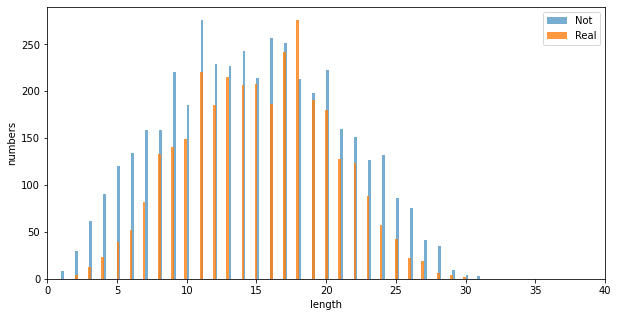

In [127]:
##### Analyzing distribution of number of words in 1/0 tweets

train_data['num_words'] = train_data['text'].apply(lambda x : len(x.split()))
test_data['num_words'] = test_data['text'].apply(lambda x : len(x.split()))

plt.figure(figsize = (10,5))
plt.hist(train_data[train_data['target'] == 0]['num_words'], alpha = 0.6, bins=bins, label='Not')
plt.hist(train_data[train_data['target'] == 1]['num_words'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,40)
plt.show()

#### The distribution is approximately similar

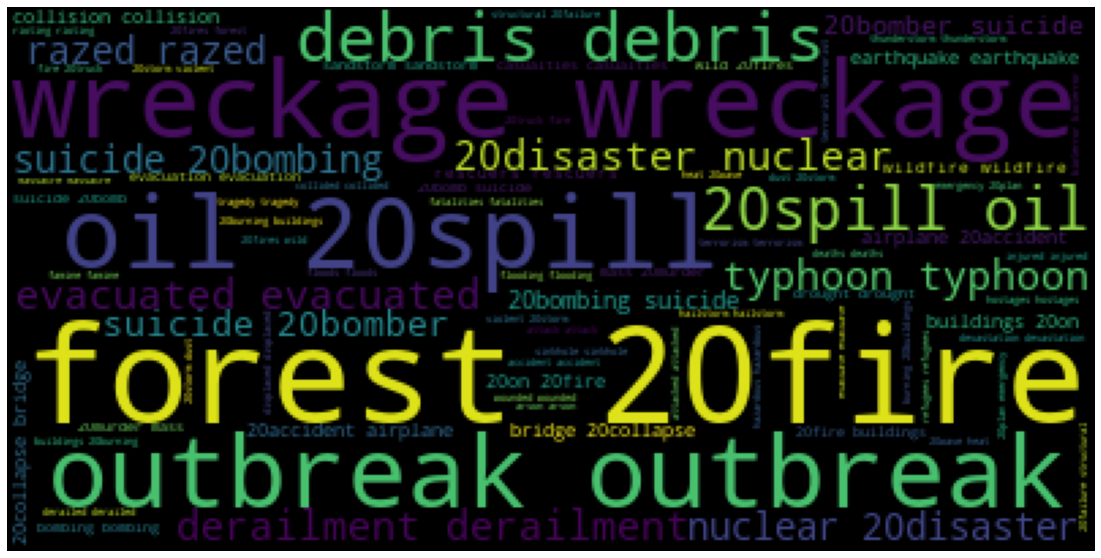

In [17]:
#### Wordcloud of keywords for trget distribution
keywords_1 = train_data[(train_data['target'] == 1) & (~pd.isna(train_data['keyword']))]['keyword'].values.tolist()
keywords_0 = train_data[(train_data['target'] == 0) & (~pd.isna(train_data['keyword']))]['keyword'].values.tolist()


#### Wordcloud for keywords belonging to target 1
plt.figure(figsize=(20,10))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(keywords_1))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()


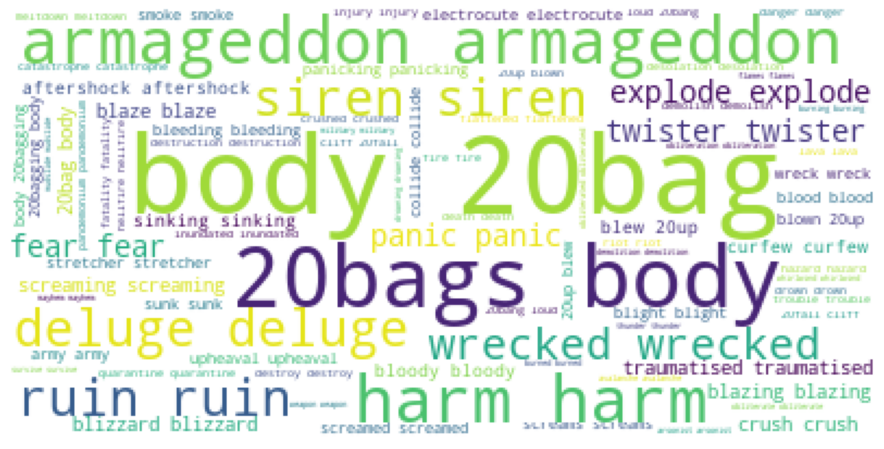

In [18]:
#### Wordcloud of keywords belonging to target 0
plt.figure(figsize=(20,8))
word_cloud = WordCloud(
                          background_color='white',
                          max_font_size = 50
                         ).generate(" ".join(keywords_0))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()


In [19]:
##### Removing stopwords, punctuations and extracting hashtags,@ and http texts.
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.probability import FreqDist
from string import punctuation

nltk.download("stopwords")
nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words("english"))
ps = PorterStemmer()
wnl = WordNetLemmatizer()

cleaned_word_corpus = []

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
contains_digit = {}
html_link_pres = {}
url_pres = {}
pos_of_keyword = {}
num_occur_key = {}
text_with_postag = {}
text_with_ner = {}
text_with_depparse = {}

import re
import string
nlp = S.load("en_core_web_sm")


In [0]:

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def cleaning_tweet(x,key):
  url = re.compile(r'https?://\S+|www\.\S+')
  html=re.compile(r'<.*?>')
  html_link_pres[x] = 'yes' if len(html.findall(x))>0 else 'no'     ### removing html
  url_pres[x] = 'yes' if len(url.findall(x))>0 else 'no'    ### removing url
  
  ####removing emojis
  x = remove_emoji(x)

  contains_digit[x] = 'yes' if len(re.findall('[0-9]+',x))>0 else 'no'

  if pd.isna(key):
    pos_of_keyword[x] = -1
    num_occur_key[x] = 0
  else:
    pos_of_keyword[x] = list(x.split()).index(key)/len(list(x.split())) if key in list(x.split()) else 0
    num_occur_key[x] = sum([1 if j==key  else 0 for j in list(x.split()) ])

  ### extract contractions
  x1 = [ contractions[j] if j in list(contractions.keys()) else j for i in sent_tokenize(x) for j in word_tokenize(i)  ]
  
  ### removing stopwords
  x2 = [ i for i in x1 if i not in stop_words]
  
  ### removing punctuations
  x3  = " ".join([w for w in x2  if w not in string.punctuation])
  x4 = re.sub('[0-9]+', '', x3)
  
  doc = nlp(x4)
  ### pos tagging clean words
  text_with_postag[x] = [ '/'.join(list(i)) for i in [ (token.text,token.pos_) for token in doc] ]

  ### dependency parsing tags
  text_with_depparse[x] = [ '/'.join(list(i)) for i in [ (token.text,token.dep_) for token in doc] ]

  ### ner tagging of words
  text_with_ner[x] = [ '/'.join(list(i)) for i in [ (token.text,token.label_) for token in doc.ents] ]

  ### clean text
  clean_text = [ token.lemma_.lower() for token in doc if token.lemma_.lower() not in string.punctuation ]
  
  return clean_text

In [0]:
train_data['flag'] = ['train']*train_data.shape[0]
test_data['flag'] = ['test']*test_data.shape[0]
total_data = pd.concat([train_data.drop(['target'],axis = 1),test_data],axis = 0)

In [0]:
total_data['clean_text'] = total_data[['text','keyword']].apply(lambda u : cleaning_tweet(u[0],u[1]),axis = 1)

In [0]:
train_data = train_data[train_data['flag'] == 'train']
test_data = test_data[test_data['flag'] == 'test']

In [150]:
total_data

,id,keyword,location,text,len_char,num_words,flag,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,69,13,train,"[-pron-, deeds, reason, earthquake, may, allah..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,38,7,train,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,133,22,train,"[all, resident, ask, shelter, place, notify, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",65,8,train,"[people, receive, wildfire, evacuation, order,..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,88,16,train,"[just, get, send, photo, ruby, alaska, smoke, ..."
...,...,...,...,...,...,...,...,...
3247,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,55,8,test,"[earthquake, safety, los, angeles, ûò, safety..."
3248,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,139,23,test,"[storm, ri, bad, last, hurricane, -pron-, city..."
3249,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,55,6,test,"[green, line, derailment, chicago, http, //t.c..."
3250,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,65,7,test,"[meg, issue, hazardous, weather, outlook, hwo,..."
